In [29]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import matplotlib.dates as mdates
from pylab import rcParams
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import mplfinance as mpf
import bs4 as bs
import pickle
import requests
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

test_size = 0.2
valid_size = 0.2
N = 21

n_estimators = 100
max_depth = 3
learning_rate = 0.1
min_child_weight = 1
subsample = 1
colsample_bytree = 1
colsample_bylevel = 1
gamma = 0
model_seed = 100

style.use('seaborn-darkgrid')

In [6]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    ticker = ticker[:-1]
    tickers.append(ticker)
for n, i in enumerate(tickers):
    if i == 'BRK.B':
        tickers[n] = 'BRKB'
    elif i == 'BF.B':
        tickers[n] = 'BFB'

with open('sp500tickers.pickle', 'wb') as f:
    pickle.dump(tickers, f)

tickers

['MMM',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN',
 'ALLE',
 'ADS',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AIV',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BKR',
 'BLL',
 'BAC',
 'BK',
 'BAX',
 'BDX',
 'BRKB',
 'BBY',
 'BIIB',
 'BLK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BFB',
 'CHRW',
 'COG',
 'CDNS',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CTL',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA',
 'CAG',
 'CXO',


In [3]:
with open('sp500tickers.pickle', 'rb') as f:
        tickers = pickle.load(f)
if not os.path.exists('stock_dfs'):
    os.makedirs('stock_dfs')
start = dt.datetime(2010, 1, 1)
end = dt.datetime.now()
for ticker in tickers:
    try:
        symbols = '_,.'
        for c in symbols:
            if c in ticker:
                ticker.replace(c, '')
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker, 'yahoo', start, end)
            df. reset_index(inplace = True)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
    except KeyError:
        continue
    else:
        print('Already have {}'.format(ticker))

Already have MMM
Already have ABT
Already have ABBV
Already have ABMD
Already have ACN
Already have ATVI
Already have ADBE
Already have AMD
Already have AAP
Already have AES
Already have AFL
Already have A
Already have APD
Already have AKAM
Already have ALK
Already have ALB
Already have ARE
Already have ALXN
Already have ALGN
Already have ALLE
Already have ADS
Already have LNT
Already have ALL
Already have GOOGL
Already have GOOG
Already have MO
Already have AMZN
Already have AMCR
Already have AEE
Already have AAL
Already have AEP
Already have AXP
Already have AIG
Already have AMT
Already have AWK
Already have AMP
Already have ABC
Already have AME
Already have AMGN
Already have APH
Already have ADI
Already have ANSS
Already have ANTM
Already have AON
Already have AOS
Already have APA
Already have AIV
Already have AAPL
Already have AMAT
Already have APTV
Already have ADM
Already have ANET
Already have AJG
Already have AIZ
Already have T
Already have ATO
Already have ADSK
Already have AD

In [4]:
with open('sp500tickers.pickle', 'rb') as f:
    tickers = pickle.load(f)

main_df = pd.DataFrame()

for count,ticker in enumerate(tickers):
    try:
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker), index_col = 0)
        df['{}_HL_PCT_DIFF'.format(ticker)] = (df['High'] - df['Low']) / df['Low']
        df['{}_PCT_CHNG'.format(ticker)] = (df['Close'] - df['Open']) / df['Open']
        df.rename(columns={'Adj Close':ticker}, inplace = True)
        df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis = 1, inplace = True)
    except OSError as err:
        print('OS error: {}'.format(err))
    if main_df.empty:
        main_df = df
    else:
        main_df = main_df.merge(df, how = 'outer')
    if count % 10 == 0:
        print(count)

main_df.to_csv('sp500_joined_closes.csv')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500


In [2]:
df = pd.read_csv('sp500_joined_closes.csv', index_col = 0)
df_columns = df.columns.values.tolist()
df_columns.remove('Date')
df.head()

,Date,MMM,MMM_HL_PCT_DIFF,MMM_PCT_CHNG,ABT,ABT_HL_PCT_DIFF,ABT_PCT_CHNG,ABBV,ABBV_HL_PCT_DIFF,ABBV_PCT_CHNG,...,ZBRA_PCT_CHNG,ZBH,ZBH_HL_PCT_DIFF,ZBH_PCT_CHNG,ZION,ZION_HL_PCT_DIFF,ZION_PCT_CHNG,ZTS,ZTS_HL_PCT_DIFF,ZTS_PCT_CHNG
0,2010-01-04,62.895260,0.009435,-0.000842,20.301096,0.011869,0.004982,NaN,NaN,NaN,...,0.007025,55.684834,0.013994,0.011971,11.942696,0.038043,0.030139,NaN,NaN,NaN
1,2010-01-05,62.501301,0.018727,-0.003623,20.137075,0.013395,-0.008261,NaN,NaN,NaN,...,0.002452,57.447594,0.021929,0.009785,12.363780,0.045352,0.039157,NaN,NaN,NaN
2,2010-01-06,63.387695,0.013052,-0.002504,20.248909,0.010028,0.007045,NaN,NaN,NaN,...,0.036118,57.429047,0.010574,-0.002578,13.438891,0.098829,0.097293,NaN,NaN,NaN
3,2010-01-07,63.433144,0.019971,0.004921,20.416655,0.013131,0.008470,NaN,NaN,NaN,...,-0.019129,58.746487,0.024775,0.007478,14.944045,0.137124,0.114228,NaN,NaN,NaN
4,2010-01-08,63.880119,0.012245,0.007528,20.521032,0.010424,0.005296,NaN,NaN,NaN,...,0.000725,57.512539,0.028478,0.002912,14.702147,0.073454,0.013589,NaN,NaN,NaN


In [3]:
df.isnull().sum()

Date                  0
MMM                   0
MMM_HL_PCT_DIFF       0
MMM_PCT_CHNG          0
ABT                   0
                   ... 
ZION_HL_PCT_DIFF      0
ZION_PCT_CHNG         0
ZTS                 775
ZTS_HL_PCT_DIFF     775
ZTS_PCT_CHNG        775
Length: 1516, dtype: int64

In [4]:
df = df.fillna(method = 'ffill')
df.isnull().sum()

Date                  0
MMM                   0
MMM_HL_PCT_DIFF       0
MMM_PCT_CHNG          0
ABT                   0
                   ... 
ZION_HL_PCT_DIFF      0
ZION_PCT_CHNG         0
ZTS                 775
ZTS_HL_PCT_DIFF     775
ZTS_PCT_CHNG        775
Length: 1516, dtype: int64

In [7]:
for i in range(1, N+1):
    for ticker in tickers:
        df['{}_{}D'.format(ticker, i)] = (df[ticker].shift(-1) - df[ticker]) / df[ticker]
    
df = df[N:]

df

,Date,MMM,MMM_HL_PCT_DIFF,MMM_PCT_CHNG,ABT,ABT_HL_PCT_DIFF,ABT_PCT_CHNG,ABBV,ABBV_HL_PCT_DIFF,ABBV_PCT_CHNG,...,WYNN_21D,XEL_21D,XRX_21D,XLNX_21D,XYL_21D,YUM_21D,ZBRA_21D,ZBH_21D,ZION_21D,ZTS_21D
21,2010-02-03,61.743717,0.023174,0.020919,20.520704,0.012569,0.005150,NaN,NaN,NaN,...,-0.052926,-0.032983,-0.037820,-5.018320e-02,NaN,-0.054895,-0.018574,-0.026431,-6.068712e-02,NaN
22,2010-02-04,60.008858,0.029177,-0.023666,20.209040,0.017847,-0.016986,NaN,NaN,NaN,...,0.008711,-0.004943,-0.020810,1.460463e-02,NaN,-0.012575,0.020818,-0.003416,2.915947e-02,NaN
23,2010-02-05,59.501259,0.028993,-0.007832,20.265368,0.015572,0.006340,NaN,NaN,NaN,...,-0.009940,-0.004471,-0.002362,-2.053629e-07,NaN,-0.007883,0.013719,-0.000181,-2.365459e-07,NaN
24,2010-02-08,58.736065,0.015922,-0.012105,20.032562,0.012005,-0.009285,NaN,NaN,NaN,...,0.014318,0.007984,-0.008284,1.491911e-02,NaN,0.010697,0.027067,0.011909,1.222919e-02,NaN
25,2010-02-09,59.637608,0.019384,0.005621,20.032562,0.011999,-0.005406,NaN,NaN,NaN,...,-0.003732,-0.006930,0.008353,5.880223e-03,NaN,0.002721,0.021368,0.010699,1.702371e-02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,2020-05-29,156.440002,0.024959,0.006045,94.919998,0.053333,0.021744,92.669998,0.036719,0.018352,...,0.038305,0.011072,0.070529,-1.196301e-02,-0.005125,0.008804,0.013968,0.012189,1.549676e-02,-0.007533
2619,2020-06-01,155.580002,0.017174,-0.002373,93.010002,0.020860,0.000646,90.699997,0.026133,-0.014666,...,-0.027408,0.004867,0.012353,2.476610e-02,0.028788,0.018670,-0.003321,0.004692,8.977437e-04,0.022698
2620,2020-06-02,157.639999,0.012577,0.005678,92.620003,0.015148,-0.003229,91.040001,0.018323,0.000769,...,0.111772,0.011352,0.042998,2.459722e-02,0.032106,0.025485,0.018668,0.014710,6.098657e-02,0.007422
2621,2020-06-03,161.210007,0.019808,0.011672,91.400002,0.023631,-0.012532,90.889999,0.021205,-0.006341,...,0.006471,-0.037713,-0.023955,-2.935305e-03,-0.006916,0.000529,-0.034644,-0.008016,3.099460e-02,-0.019996


In [8]:
df = df.fillna(0)
df

,Date,MMM,MMM_HL_PCT_DIFF,MMM_PCT_CHNG,ABT,ABT_HL_PCT_DIFF,ABT_PCT_CHNG,ABBV,ABBV_HL_PCT_DIFF,ABBV_PCT_CHNG,...,WYNN_21D,XEL_21D,XRX_21D,XLNX_21D,XYL_21D,YUM_21D,ZBRA_21D,ZBH_21D,ZION_21D,ZTS_21D
21,2010-02-03,61.743717,0.023174,0.020919,20.520704,0.012569,0.005150,0.000000,0.000000,0.000000,...,-0.052926,-0.032983,-0.037820,-5.018320e-02,0.000000,-0.054895,-0.018574,-0.026431,-6.068712e-02,0.000000
22,2010-02-04,60.008858,0.029177,-0.023666,20.209040,0.017847,-0.016986,0.000000,0.000000,0.000000,...,0.008711,-0.004943,-0.020810,1.460463e-02,0.000000,-0.012575,0.020818,-0.003416,2.915947e-02,0.000000
23,2010-02-05,59.501259,0.028993,-0.007832,20.265368,0.015572,0.006340,0.000000,0.000000,0.000000,...,-0.009940,-0.004471,-0.002362,-2.053629e-07,0.000000,-0.007883,0.013719,-0.000181,-2.365459e-07,0.000000
24,2010-02-08,58.736065,0.015922,-0.012105,20.032562,0.012005,-0.009285,0.000000,0.000000,0.000000,...,0.014318,0.007984,-0.008284,1.491911e-02,0.000000,0.010697,0.027067,0.011909,1.222919e-02,0.000000
25,2010-02-09,59.637608,0.019384,0.005621,20.032562,0.011999,-0.005406,0.000000,0.000000,0.000000,...,-0.003732,-0.006930,0.008353,5.880223e-03,0.000000,0.002721,0.021368,0.010699,1.702371e-02,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,2020-05-29,156.440002,0.024959,0.006045,94.919998,0.053333,0.021744,92.669998,0.036719,0.018352,...,0.038305,0.011072,0.070529,-1.196301e-02,-0.005125,0.008804,0.013968,0.012189,1.549676e-02,-0.007533
2619,2020-06-01,155.580002,0.017174,-0.002373,93.010002,0.020860,0.000646,90.699997,0.026133,-0.014666,...,-0.027408,0.004867,0.012353,2.476610e-02,0.028788,0.018670,-0.003321,0.004692,8.977437e-04,0.022698
2620,2020-06-02,157.639999,0.012577,0.005678,92.620003,0.015148,-0.003229,91.040001,0.018323,0.000769,...,0.111772,0.011352,0.042998,2.459722e-02,0.032106,0.025485,0.018668,0.014710,6.098657e-02,0.007422
2621,2020-06-03,161.210007,0.019808,0.011672,91.400002,0.023631,-0.012532,90.889999,0.021205,-0.006341,...,0.006471,-0.037713,-0.023955,-2.935305e-03,-0.006916,0.000529,-0.034644,-0.008016,3.099460e-02,-0.019996


In [9]:
df = df.astype({'Date':'datetime64'})
df.dtypes

Date               datetime64[ns]
MMM                       float64
MMM_HL_PCT_DIFF           float64
MMM_PCT_CHNG              float64
ABT                       float64
                        ...      
YUM_21D                   float64
ZBRA_21D                  float64
ZBH_21D                   float64
ZION_21D                  float64
ZTS_21D                   float64
Length: 12121, dtype: object

In [10]:
GSPC = web.DataReader('^GSPC', 'yahoo', dt.datetime(2010, 2, 3), dt.datetime(2020, 6, 4))
GSPC = GSPC.reset_index()
GSPC = GSPC.rename(columns = {'Adj Close':'GSPC'})
GSPC = GSPC[['Date', 'GSPC']]
GSPC

,Date,GSPC
0,2010-02-03,1097.280029
1,2010-02-04,1063.109985
2,2010-02-05,1066.189941
3,2010-02-08,1056.739990
4,2010-02-09,1070.520020
...,...,...
2597,2020-05-29,3044.310059
2598,2020-06-01,3055.729980
2599,2020-06-02,3080.820068
2600,2020-06-03,3122.870117


In [11]:
GSPC.dtypes

Date    datetime64[ns]
GSPC           float64
dtype: object

In [12]:
df = pd.merge(df, GSPC, how = 'outer', on = 'Date')
df

,Date,MMM,MMM_HL_PCT_DIFF,MMM_PCT_CHNG,ABT,ABT_HL_PCT_DIFF,ABT_PCT_CHNG,ABBV,ABBV_HL_PCT_DIFF,ABBV_PCT_CHNG,...,XEL_21D,XRX_21D,XLNX_21D,XYL_21D,YUM_21D,ZBRA_21D,ZBH_21D,ZION_21D,ZTS_21D,GSPC
0,2010-02-03,61.743717,0.023174,0.020919,20.520704,0.012569,0.005150,0.000000,0.000000,0.000000,...,-0.032983,-0.037820,-5.018320e-02,0.000000,-0.054895,-0.018574,-0.026431,-6.068712e-02,0.000000,1097.280029
1,2010-02-04,60.008858,0.029177,-0.023666,20.209040,0.017847,-0.016986,0.000000,0.000000,0.000000,...,-0.004943,-0.020810,1.460463e-02,0.000000,-0.012575,0.020818,-0.003416,2.915947e-02,0.000000,1063.109985
2,2010-02-05,59.501259,0.028993,-0.007832,20.265368,0.015572,0.006340,0.000000,0.000000,0.000000,...,-0.004471,-0.002362,-2.053629e-07,0.000000,-0.007883,0.013719,-0.000181,-2.365459e-07,0.000000,1066.189941
3,2010-02-08,58.736065,0.015922,-0.012105,20.032562,0.012005,-0.009285,0.000000,0.000000,0.000000,...,0.007984,-0.008284,1.491911e-02,0.000000,0.010697,0.027067,0.011909,1.222919e-02,0.000000,1056.739990
4,2010-02-09,59.637608,0.019384,0.005621,20.032562,0.011999,-0.005406,0.000000,0.000000,0.000000,...,-0.006930,0.008353,5.880223e-03,0.000000,0.002721,0.021368,0.010699,1.702371e-02,0.000000,1070.520020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,2020-05-29,156.440002,0.024959,0.006045,94.919998,0.053333,0.021744,92.669998,0.036719,0.018352,...,0.011072,0.070529,-1.196301e-02,-0.005125,0.008804,0.013968,0.012189,1.549676e-02,-0.007533,3044.310059
2598,2020-06-01,155.580002,0.017174,-0.002373,93.010002,0.020860,0.000646,90.699997,0.026133,-0.014666,...,0.004867,0.012353,2.476610e-02,0.028788,0.018670,-0.003321,0.004692,8.977437e-04,0.022698,3055.729980
2599,2020-06-02,157.639999,0.012577,0.005678,92.620003,0.015148,-0.003229,91.040001,0.018323,0.000769,...,0.011352,0.042998,2.459722e-02,0.032106,0.025485,0.018668,0.014710,6.098657e-02,0.007422,3080.820068
2600,2020-06-03,161.210007,0.019808,0.011672,91.400002,0.023631,-0.012532,90.889999,0.021205,-0.006341,...,-0.037713,-0.023955,-2.935305e-03,-0.006916,0.000529,-0.034644,-0.008016,3.099460e-02,-0.019996,3122.870117


In [13]:
valid_len = int(valid_size * len(df))
test_len = int(test_size * len(df))
train_len = len(df) - (valid_len + test_len)
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))
print('Valid Set Len: ' + str(valid_len))

train = df[:train_len]
valid = df[train_len:(train_len + valid_len)]
test = df[(train_len + valid_len):]
print('Train Set Shape: ' + str(train.shape))
print('Valid Set Shape: ' + str(valid.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 1562
Test Set Len: 520
Valid Set Len: 520
Train Set Shape: (1562, 12122)
Valid Set Shape: (520, 12122)
Test Set Shape: (520, 12122)


In [14]:
features_list = []

for num in range(1, N+1):
    for ticker in tickers:
        features_list.append('{}_{}D'.format(ticker, num))
    
target = 'GSPC'

X_train = train[features_list]
y_train = train[target]
X_valid = valid[features_list]
y_valid = valid[target]
X_test = test[features_list]
y_test = test[target]

In [15]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

In [16]:
model = XGBRegressor()

model.fit(X_train_scaled, y_train_scaled)

predict_train_scaled = model.predict(X_train_scaled)
predict_train = scaler.inverse_transform(predict_train_scaled.reshape(-1, 1))

print('MSE on Train Set =', mean_squared_error(y_train, predict_train))
print('MAE on Train Set =', mean_absolute_error(y_train, predict_train))

MSE on Train Set = 0.03185135996381772
MAE on Train Set = 0.12872724740667013


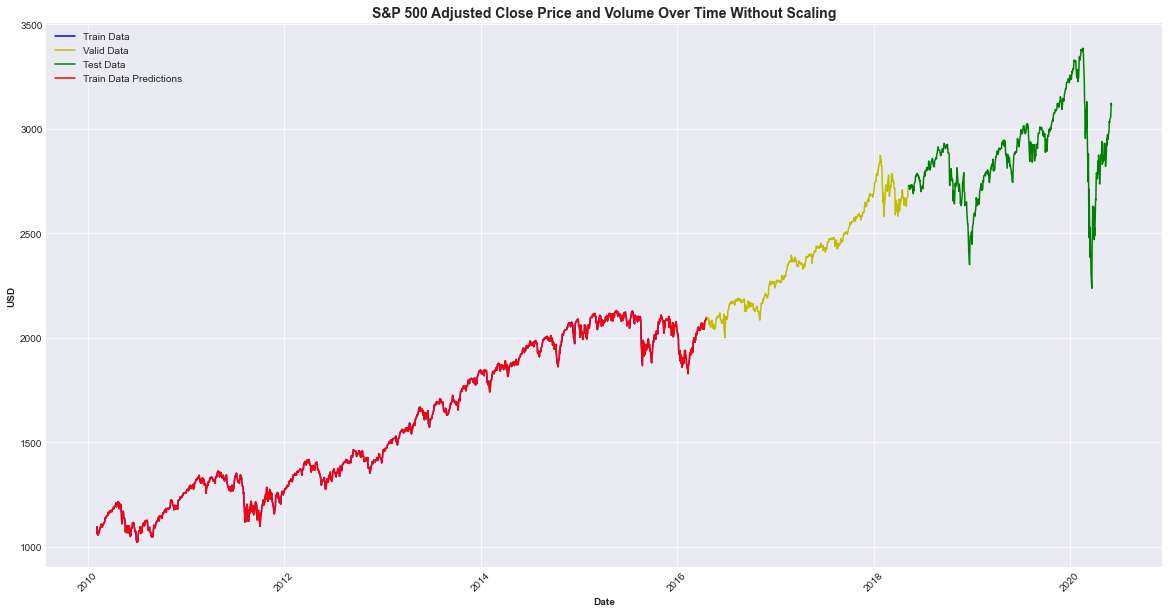

In [17]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.plot(train['Date'], train['GSPC'], 'b-')
plt.plot(valid['Date'], valid['GSPC'], 'y-')
plt.plot(test['Date'], test['GSPC'], 'g-')
plt.plot(train['Date'], predict_train, 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Train Data Predictions'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('S&P 500 Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

plt.show()

In [22]:
predict_valid_scaled = model.predict(X_valid_scaled)
predict_valid = scaler.inverse_transform(predict_valid_scaled.reshape(-1, 1))

print('MSE on Validation Set =', mean_squared_error(y_valid, predict_valid))
print('MAE on Validation Set =', mean_absolute_error(y_valid, predict_valid))

MSE on Validation Set = 171631.51418862026
MAE on Validation Set = 348.88945852426383


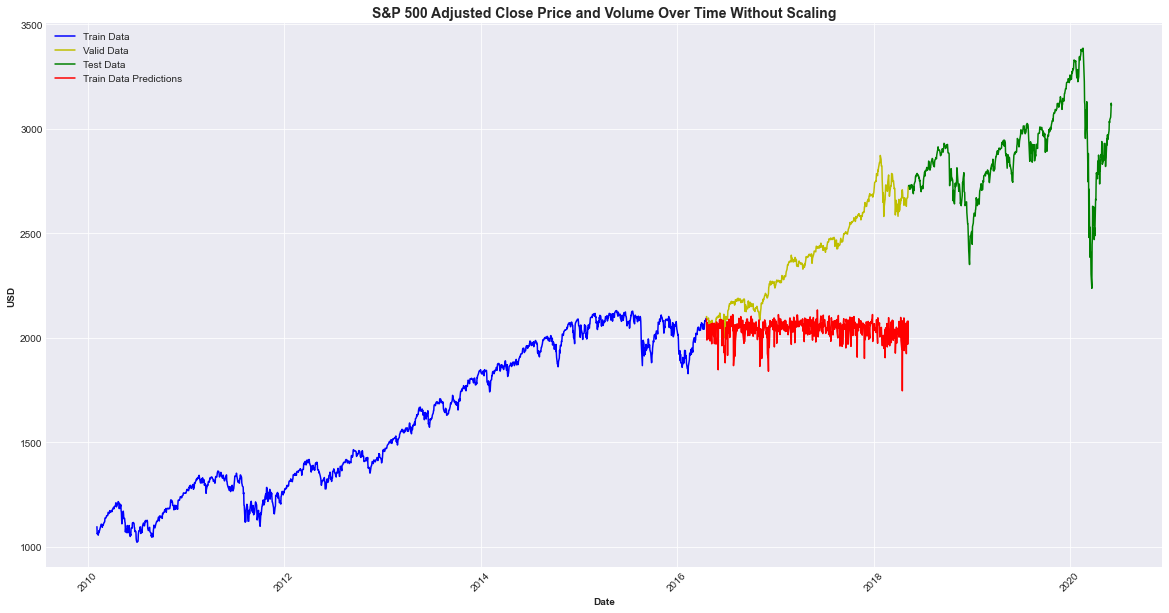

In [23]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.plot(train['Date'], train['GSPC'], 'b-')
plt.plot(valid['Date'], valid['GSPC'], 'y-')
plt.plot(test['Date'], test['GSPC'], 'g-')
plt.plot(valid['Date'], predict_valid, 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Train Data Predictions'])
plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)
plt.ylabel('USD', fontweight = 'bold')
plt.title('S&P 500 Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.show()

In [24]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

In [25]:
model = XGBRegressor()

model.fit(X_train_scaled, y_train_scaled)

predict_train_scaled = model.predict(X_train_scaled)
predict_train = scaler.inverse_transform(predict_train_scaled.reshape(-1, 1))

print('MSE on Train Set =', mean_squared_error(y_train, predict_train))
print('MAE on Train Set =', mean_absolute_error(y_train, predict_train))

MSE on Train Set = 0.19744908737159417
MAE on Train Set = 0.32133063830425734


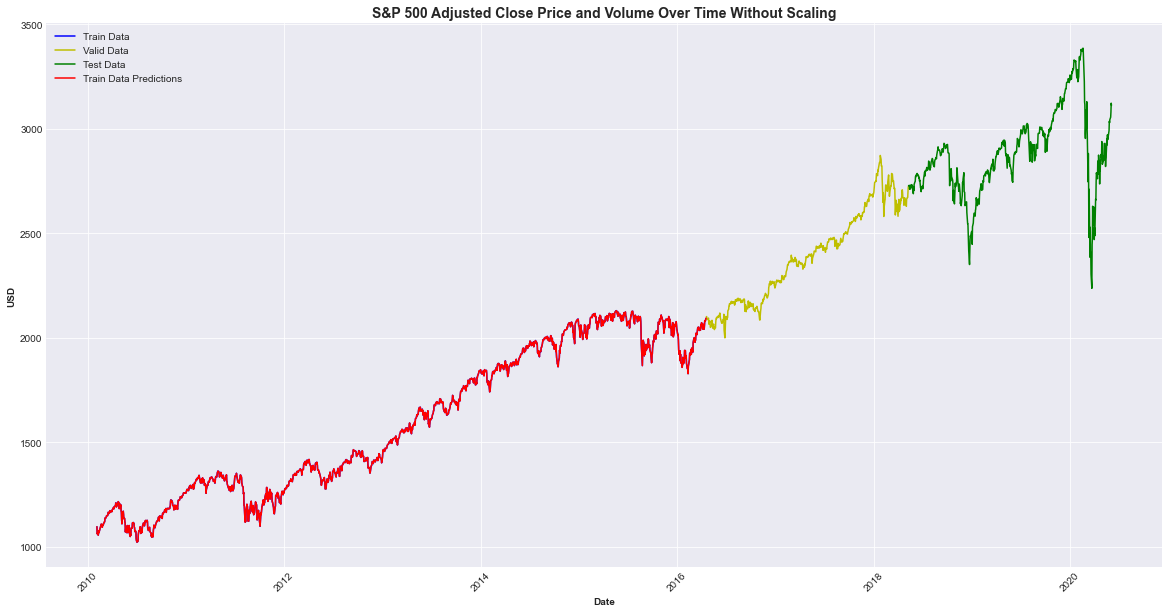

In [26]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.plot(train['Date'], train['GSPC'], 'b-')
plt.plot(valid['Date'], valid['GSPC'], 'y-')
plt.plot(test['Date'], test['GSPC'], 'g-')
plt.plot(train['Date'], predict_train, 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Train Data Predictions'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('S&P 500 Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

plt.show()

In [27]:
predict_valid_scaled = model.predict(X_valid_scaled)
predict_valid = scaler.inverse_transform(predict_valid_scaled.reshape(-1, 1))

print('MSE on Validation Set =', mean_squared_error(y_valid, predict_valid))
print('MAE on Validation Set =', mean_absolute_error(y_valid, predict_valid))

MSE on Validation Set = 174410.16797373738
MAE on Validation Set = 354.297506244366


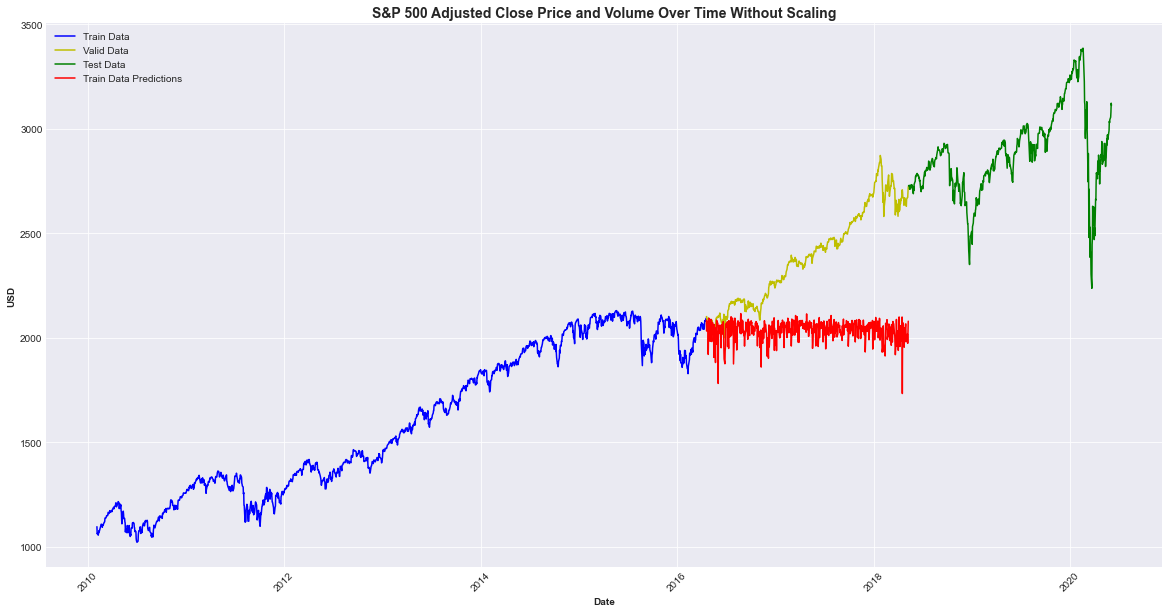

In [28]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.plot(train['Date'], train['GSPC'], 'b-')
plt.plot(valid['Date'], valid['GSPC'], 'y-')
plt.plot(test['Date'], test['GSPC'], 'g-')
plt.plot(valid['Date'], predict_valid, 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Train Data Predictions'])
plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)
plt.ylabel('USD', fontweight = 'bold')
plt.title('S&P 500 Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.show()

In [35]:
# Create parameter grid

param_grid = {
    "learning_rate": [0.05, 0.075, 0.1, 0.2, 0.3, 0.4],
    "max_depth": [1, 2, 3, 4, 5, 6, 7],
    "reg_lambda": [1, 1.5, 2, 3, 4.5],
    "min_child_weight": [1, 3, 5, 7],
    "n_estimators": [50, 100, 200, 300, 400, 500, 1000]
}

kfold = KFold(n_splits = 10)


# Create RandomizedSearchCV Object
xgb_rscv = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

# Fit the model
model_xgboost = xgb_rscv.fit(X_valid_scaled, y_valid)

Learning Rate:  0.1
Max Depth:  2
Number of Trees:  500


In [ ]:
model_xgboost.best_params_

In [36]:
predict_test_scaled = model_xgboost.predict(X_test_scaled)
predict_test = scaler.inverse_transform(predict_test_scaled.reshape(-1, 1))

print('MSE on Test Set =', mean_squared_error(y_test, predict_test))
print('MAE on Test Set =', mean_absolute_error(y_test, predict_test))

MSE on Test Set = 800387344139.8735
MAE on Test Set = 894359.8776198167


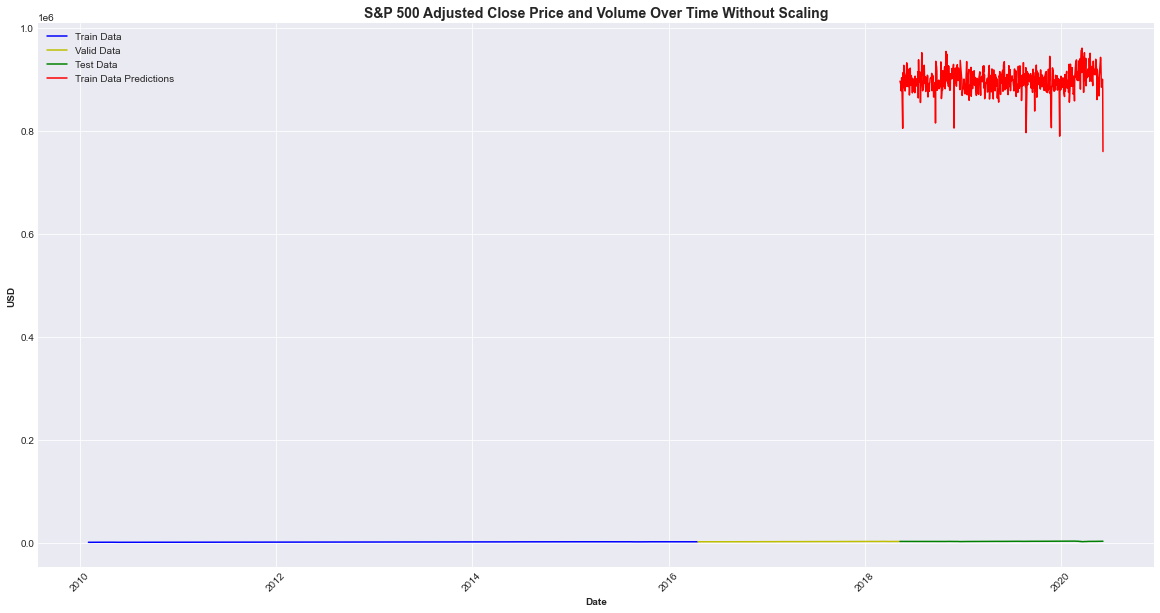

In [37]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.plot(train['Date'], train['GSPC'], 'b-')
plt.plot(valid['Date'], valid['GSPC'], 'y-')
plt.plot(test['Date'], test['GSPC'], 'g-')
plt.plot(test['Date'], predict_test, 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Train Data Predictions'])
plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)
plt.ylabel('USD', fontweight = 'bold')
plt.title('S&P 500 Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.show()

In [ ]:
# Create parameter grid
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500, 1000]}


# Create RandomizedSearchCV Object
xgb_rscv = GridSearchCV(XGBRegressor(), param_grid = parameters)

# Fit the model
model_xgboost = xgb_rscv.fit(X_valid_scaled, y_valid)

# Model best estimators
print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
print("Max Features at Split: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
print("Minimum Sum of the Instance Weight Hessian to Make a Child: ",
      model_xgboost.best_estimator_.get_params()["min_child_weight"])
print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])

In [ ]:
predict_test_scaled = model_xgboost.predict(X_test_scaled)
predict_test = scaler.inverse_transform(predict_test_scaled.reshape(-1, 1))

print('MSE on Test Set =', mean_squared_error(y_test, predict_test))
print('MAE on Test Set =', mean_absolute_error(y_test, predict_test))

In [ ]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.plot(train['Date'], train['GSPC'], 'b-')
plt.plot(valid['Date'], valid['GSPC'], 'y-')
plt.plot(test['Date'], test['GSPC'], 'g-')
plt.plot(test['Date'], predict_test, 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Train Data Predictions'])
plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)
plt.ylabel('USD', fontweight = 'bold')
plt.title('S&P 500 Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.show()